# Fake News Detection

## Imports

In [52]:
import numpy as np
import pandas as pd
import re
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

**Dataset**

In [2]:
data = pd.read_excel('../data/news_dataset_small.xlsx')

In [3]:
data.head()

,text,label
0,No comment is expected from Barack Obama Membe...,fake
1,Did they post their votes for Hillary already?,fake
2,"Now, most of the demonstrators gathered last ...",fake
3,A dozen politically active pastors came here f...,real
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",fake


In [4]:
data.shape

(14998, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14998 entries, 0 to 14997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14998 non-null  object
 1   label   14998 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


## Data Cleaning

**Strategy:**
1. Replace `â€`, `â€œ`, `â€˜`, `â€™` with `BLANK`.
2. Transform the text to lowercase.
3. Remove `httpS+`, `bit.ly/S+` from text.

In [6]:
# Funtion for cleaning the news text
def clean_news(news):
    cleaned_news = news.replace("â€", "").replace("â€œ", "").replace("â€˜", "").replace("â€™", "")
    cleaned_news = news.lower()
    cleaned_news = re.sub(r'httpS+', '', cleaned_news)
    cleaned_news = re.sub(r'bit.ly/S+', '', cleaned_news)

    return cleaned_news

In [7]:
cleaned_data = data.copy()

cleaned_data['text'] = data['text'].apply(clean_news)

In [8]:
cleaned_data['text'][:5]

0    no comment is expected from barack obama membe...
1       did they post their votes for hillary already?
2     now, most of the demonstrators gathered last ...
3    a dozen politically active pastors came here f...
4    the rs-28 sarmat missile, dubbed satan 2, will...
Name: text, dtype: object

## Exploratory Data Analysis

In [12]:
df = cleaned_data.copy()

In [23]:
# Analyzing text length
def text_length_distribution(texts, labels, colors):
    lengths = []

    for text in texts:
        lengths.append(len(text))

    df = pd.DataFrame({"text_length": lengths, "label": labels})
    fig = px.histogram(df, x="text_length", color="label", color_discrete_sequence=colors, title='Text length distribution')

    return fig

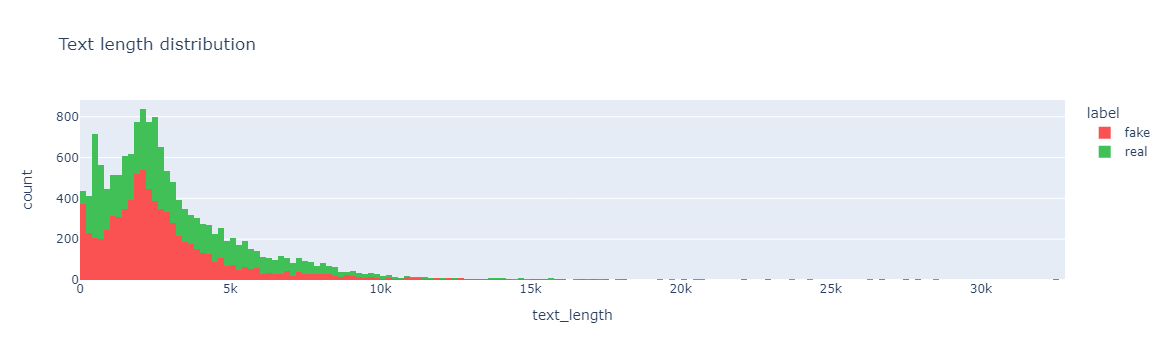

In [24]:
fig = text_length_distribution(df['text'], df['label'], colors=['#fa5252', '#40c057'])
fig.show()

In [34]:
# Analyze the distribution of fake and real news
def class_dist(data, column_name="label", colors=['#fa5252', '#40c057'], chart_title="Distribution of fake and real news"):
    df = data.groupby(by=['label']).size().reset_index().rename(columns={0: "count"})
    
    fig = px.pie(df, values="count", names="label", color_discrete_sequence=colors, title=chart_title)

    return fig

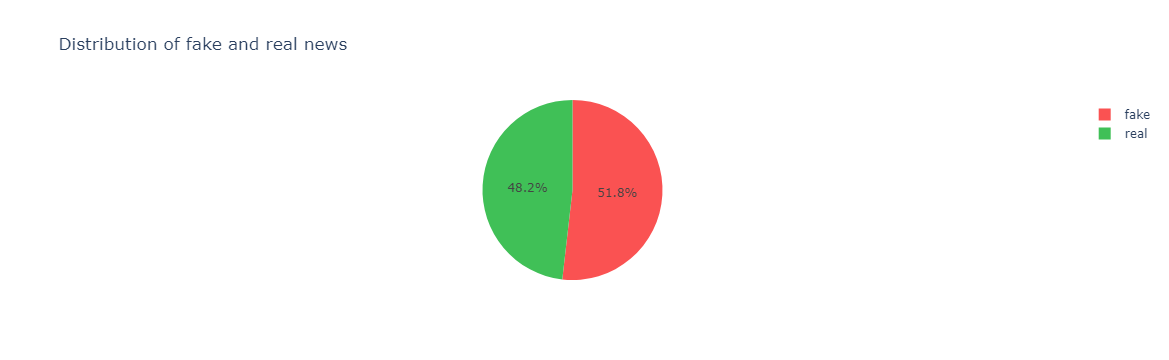

In [35]:
fig = class_dist(df)
fig.show()

In [60]:
# Visualize the Most Common Words for fake and real news
def viz_most_common_words(data, sep_column="label", colors={"fake": '#fa5252', "real": '#40c057'}, chart_title="Most common words in fake and real news"):
    fake_df = data[data[sep_column]=="fake"]
    real_df = data[data[sep_column]=="real"]

    all_fake_texts = ' '.join(fake_df['text'])
    all_real_texts = ' '.join(real_df['text'])

    fake_tokens = word_tokenize(all_fake_texts)
    real_tokens = word_tokenize(all_real_texts)

    stop_words = set(stopwords.words('english'))

    clean_fake_tokens = [token.lower() for token in fake_tokens if token.isalnum() and (token not in stop_words)]
    clean_real_tokens = [token.lower() for token in real_tokens if token.isalnum() and (token not in stop_words)]

    fake_freq_dist = pd.Series(dict(FreqDist(clean_fake_tokens).most_common(20)))
    real_freq_dist = pd.Series(dict(FreqDist(clean_real_tokens).most_common(20)))

    fig = make_subplots(rows=1, cols=2)
    
    fig.add_trace(go.Bar(x=fake_freq_dist.index, y=fake_freq_dist.values, name="fake", marker_color=colors["fake"]), row=1, col=1)
    fig.add_trace(go.Bar(x=real_freq_dist.index, y=real_freq_dist.values, name="real", marker_color=colors["real"]), row=1, col=2)
    fig.update_layout(
        title=chart_title,
        xaxis_title="Words",
        yaxis_title="Freq"
    )
    return fig

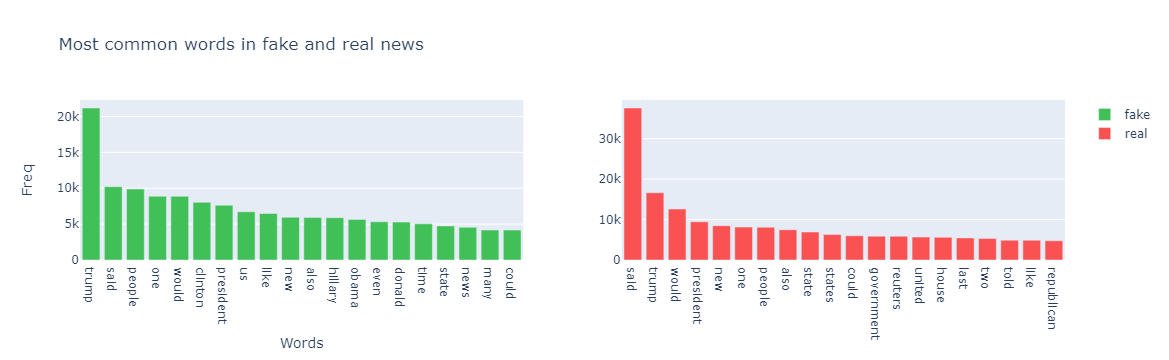

In [61]:
fig = viz_most_common_words(df)
fig.show()

## Feature engineering

**Strategy:**
1. Generate features like `chars`, `words`, `cap_chars`, `cap_words`, `punctuations`, `words_quotes`, `sentences`, `unique_words`, `htags`, `mwntions`, `stopwords`.
2. Generate features by dividing - `average_sentence_length` = `words` / `sentences`, `unique_vs_words` = `unique_words` / `words`, `stopwords_vs_words` = `stopwords` / `words`.